Bu yarışmada, ABD Ulaştırma Bakanlığı'ndan alınan uçuş verilerini içeren gerçek dünya veri setini keşfedeceksiniz.

Verileri yükleyip görüntüleyerek başlayalım.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("flights.csv")
df.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,DestAirportName,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,John F. Kennedy International,New York,NY,1539,4,0.0,1824,13,0,0
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,Chicago Midway International,Chicago,IL,710,3,0.0,740,22,1,0
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,Ronald Reagan Washington National,Washington,DC,810,-3,0.0,1614,-7,0,0
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,Cleveland-Hopkins International,Cleveland,OH,804,35,1.0,1027,33,1,0
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,Hartsfield-Jackson Atlanta International,Atlanta,GA,545,-1,0.0,728,-9,0,0


Veri seti, 2013 yılında ABD iç hat uçuşlarına ilişkin gözlemleri içerir ve aşağıdaki alanlardan oluşur:

* Year: Uçuş yılı (tüm kayıtlar 2013'e aittir)
* Month: Uçuş ayı
* DayofMonth: Uçağın kalktığı ayın günü
* DayOfWeek: Uçuşun kalktığı haftanın günü - 1'den (Pazartesi) 7'ye (Pazar)
* Carrier: Havayolunun iki harfli kısaltması.
* OriginAirportID: Kalkış havaalanı için benzersiz bir sayısal tanımlayıcı
* OriginAirportName: Kalkış havalimanının tam adı
* OriginCity: Kalkış havalimanı şehri
* OriginState: Kalkış havalimanı durumu
* DestAirportID: Hedef havaalanı için benzersiz bir sayısal tanımlayıcı
* DestAirportName: Hedef havaalanının tam adı
* DestCity: Hedef havaalanı şehri
* DestState: Hedef havaalanı durumu
* CRSDepTime: Planlanan hareket saati
* DepDelay: Kalkışın rötar yaptığı dakika sayısı (programın ilerisinde ayrılan uçuşun değeri negatiftir)
* DelDelay15: Kalkışın 15 dakikadan fazla ertelendiğini (ve bu nedenle "geç" olarak kabul edildiğini) gösteren bir ikili gösterge
* CRSArTime: Planlanan varış zamanı
* ArrDelay: Varışın geciktiği dakika sayısı (programdan önce gelen uçuşun değeri negatiftir)
* ArrDelay15: Varışın 15 dakikadan fazla geciktiğine (ve bu nedenle "geç" olarak kabul edildiğine) dair bir ikili gösterge
* Cancelled: Uçuşun iptal edildiğini gösteren ikili gösterge

## Eksik değerleri temizleme

In [3]:
df.isnull().sum()

Year                    0
Month                   0
DayofMonth              0
DayOfWeek               0
Carrier                 0
OriginAirportID         0
OriginAirportName       0
OriginCity              0
OriginState             0
DestAirportID           0
DestAirportName         0
DestCity                0
DestState               0
CRSDepTime              0
DepDelay                0
DepDel15             2761
CRSArrTime              0
ArrDelay                0
ArrDel15                0
Cancelled               0
dtype: int64

Hmm, bazı boş "geç ayrılma" göstergeleri var gibi görünüyor. Gecikme 15 dakika ve üzeri ise kalkışlar geç kabul edilir, geç göstergesi sıfır olanların gecikmelerine bir göz atalım:

In [7]:
df[df.isnull().any(axis=1)][["DepDelay", "DepDel15"]]

,DepDelay,DepDel15
171,0,NaN
359,0,NaN
429,0,NaN
545,0,NaN
554,0,NaN
...,...,...
271410,0,NaN
271607,0,NaN
271634,0,NaN
271671,0,NaN


Hepsini bu ekranda göremiyoruz ama görünüşe göre hepsi 0 gecikmeye sahip olabilir. Bu kayıtlar için özet istatistiklere bakarak kontrol edelim:

In [8]:
df[df.isnull().any(axis=1)].DepDelay.describe()

count    2761.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: DepDelay, dtype: float64

Minimum, maksimum ve ortalama değerlerin tümü 0'dır; yani görünen o ki bunların hiçbiri aslında geç kalkışlar değildi. Eksik DepDel15 göstergesini 0 ile değiştirelim ve başka eksik değer olmadığını doğrulayalım.

In [10]:
df["DepDel15"] = df["DepDel15"].fillna(0)

In [11]:
df.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
Carrier              0
OriginAirportID      0
OriginAirportName    0
OriginCity           0
OriginState          0
DestAirportID        0
DestAirportName      0
DestCity             0
DestState            0
CRSDepTime           0
DepDelay             0
DepDel15             0
CRSArrTime           0
ArrDelay             0
ArrDel15             0
Cancelled            0
dtype: int64

## Temizlenmiş aykırı değerler

DepDelay ve ArrDelay sütunları için dağıtım ve özet istatistiklerini görüntüleyin.

In [14]:
# Bir sütun için özet istatistikleri ve dağılımı gösterme işlevi
def show_distribution(var_data):

    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print(var_data.name,'\nMinimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))
    
    fig, ax = plt.subplots(2, 1, figsize = (10,8))

    ax[0].hist(var_data, color = "#01bc69")
    ax[0].set_ylabel('Frequency')
    
    ax[0].axvline(x=min_val, color = '#37a861', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = '#617367', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = '#bc55d7', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = '#a5fe4f', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = '#c993a7', linestyle='dashed', linewidth = 2)

    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')
    
    fig.suptitle(var_data.name)

    fig.show()

DepDelay 
Minimum:-63.00
Mean:10.35
Median:-1.00
Mode:-3.00
Maximum:1425.00

ArrDelay 
Minimum:-75.00
Mean:6.50
Median:-3.00
Mode:0.00
Maximum:1440.00



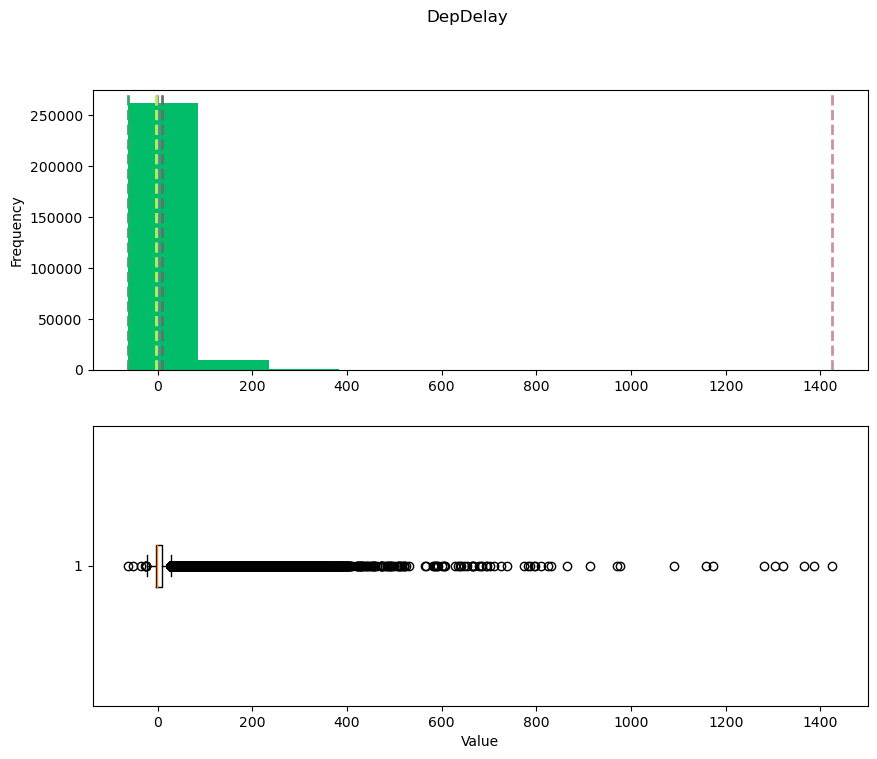

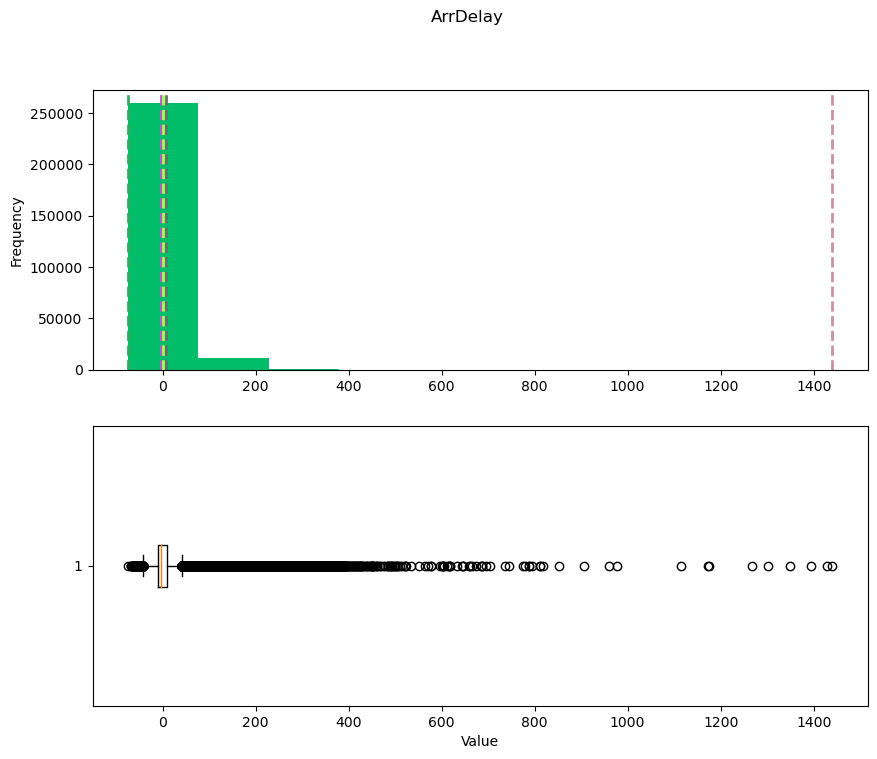

In [17]:
# Her gecikme alanı için işlevi çağırın
delay_fields = ["DepDelay", "ArrDelay"]
for col in delay_fields:
    show_distribution(df[col])

Her iki değişkenin alt ve üst uçlarında - özellikle üst uçta - aykırı değerler vardır.

Verileri, yalnızca bu alanların değerlerinin 1. ve 90. yüzdelikler içinde olduğu satırları dahil edecek şekilde kırpalım.

DepDelay 
Minimum:-11.00
Mean:-0.92
Median:-2.00
Mode:-3.00
Maximum:16.00

ArrDelay 
Minimum:-32.00
Mean:-5.03
Median:-6.00
Mode:0.00
Maximum:37.00



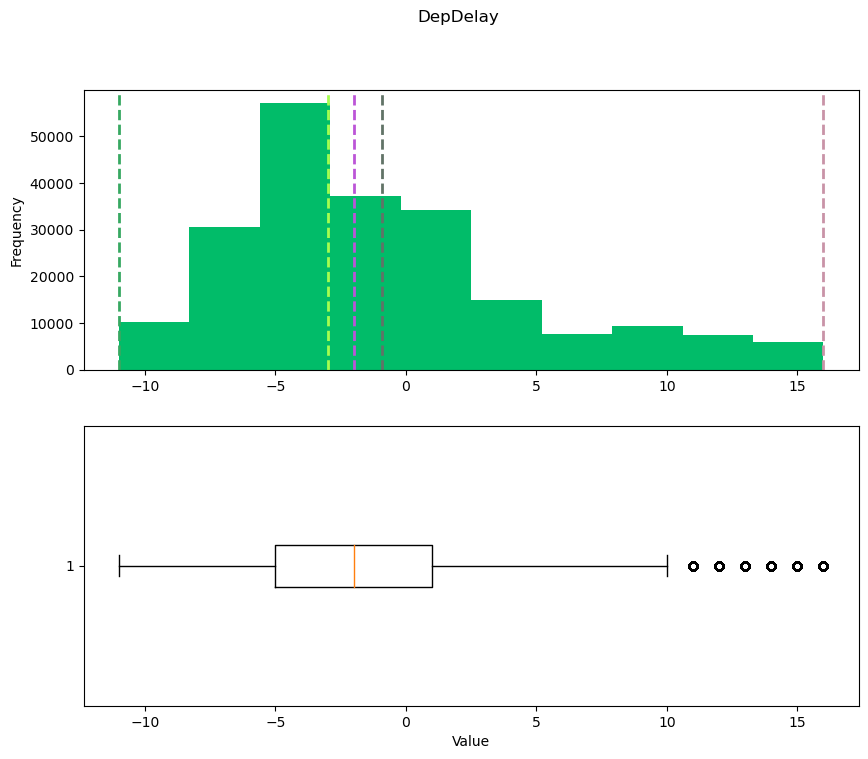

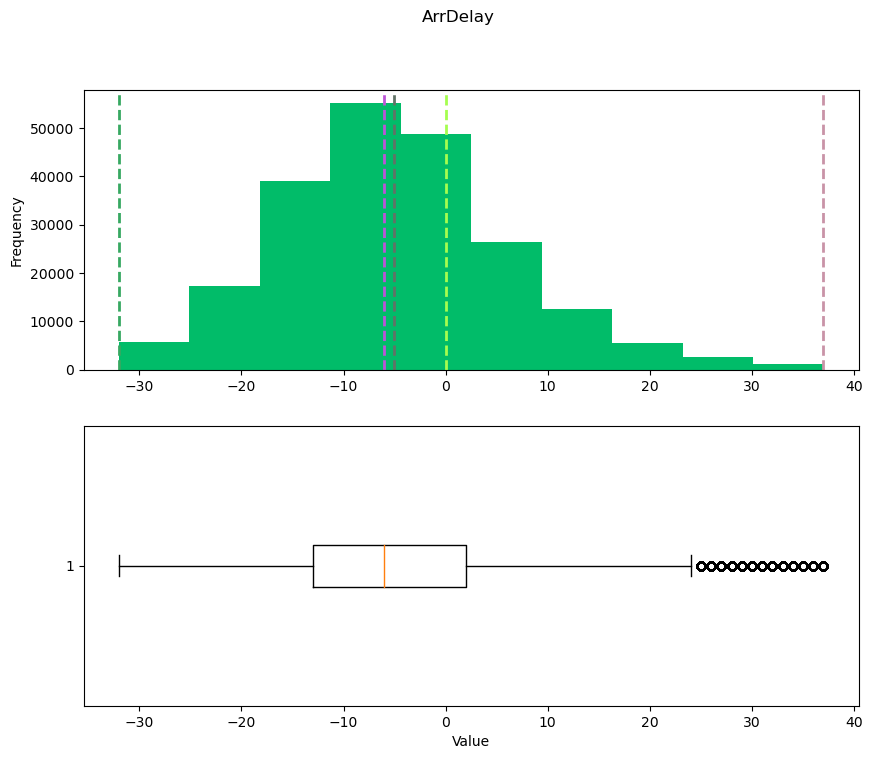

In [18]:
# ArrDelay için aykırı değerleri %1 ve %90 yüzdelik dilimlere göre kırpın
ArrDelay_01pcntile = df["ArrDelay"].quantile(0.01)
ArrDelay_90pcntile = df["ArrDelay"].quantile(0.90)

df = df[df["ArrDelay"] < ArrDelay_90pcntile]
df = df[df["ArrDelay"] > ArrDelay_01pcntile]

# DepDelay için aykırı değerleri %1 ve %90 yüzdelik dilimlere göre kırpın

DepDelay_01pcntile = df["DepDelay"].quantile(0.01)
DepDelay_90pcntile = df["DepDelay"].quantile(0.90)

df = df[df["DepDelay"] < DepDelay_90pcntile]
df = df[df["DepDelay"] > DepDelay_01pcntile]

# Revize edilmiş dağılımları görüntüleyin
for col in delay_fields:
    show_distribution(df[col])

Bu biraz daha iyi görünüyor.

## Verileri Keşfetme
Sayısal sütunlar için özet istatistiklerin genel görünümü ile başlayalım.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,214397.0,2013.000000,0.000000,2013.0,2013.0,2013.0,2013.0,2013.0
Month,214397.0,7.018368,2.006398,4.0,5.0,7.0,9.0,10.0
DayofMonth,214397.0,15.794703,8.859118,1.0,8.0,16.0,23.0,31.0
DayOfWeek,214397.0,3.902737,1.997744,1.0,2.0,4.0,6.0,7.0
OriginAirportID,214397.0,12757.827661,1510.058629,10140.0,11292.0,12892.0,14100.0,15376.0
DestAirportID,214397.0,12726.276147,1506.251757,10140.0,11292.0,12892.0,14057.0,15376.0
CRSDepTime,214397.0,1278.223879,469.440262,1.0,850.0,1235.0,1655.0,2359.0
DepDelay,214397.0,-0.921692,5.708594,-11.0,-5.0,-2.0,1.0,16.0
DepDel15,214397.0,0.018116,0.133371,0.0,0.0,0.0,0.0,1.0
CRSArrTime,214397.0,1461.406596,485.676457,1.0,1054.0,1445.0,1845.0,2359.0


**Ortalama kalkış ve varış gecikmeleri nelerdir?**

In [20]:
df[delay_fields].mean()

DepDelay   -0.921692
ArrDelay   -5.030276
dtype: float64

**Taşıyıcılar, varış gecikmesi performansı açısından nasıl karşılaştırılır?**

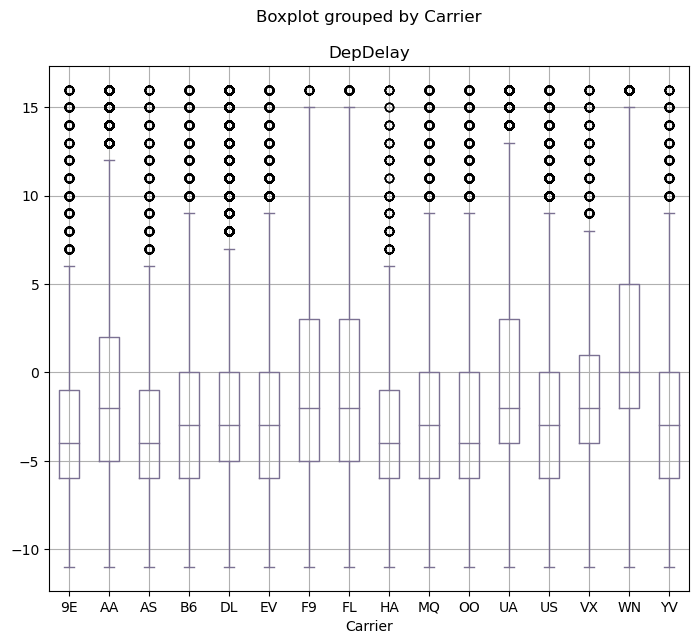

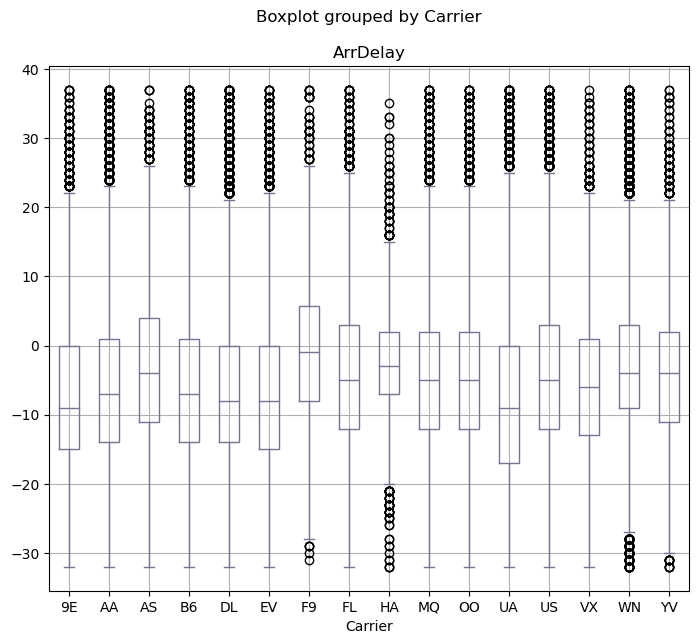

In [22]:
for col in delay_fields:
    df.boxplot(column=col, by="Carrier", figsize=(8,7), color="#7b7193")

**Haftanın bazı günleri varış günlerine diğerlerinden daha mı yatkındır?**

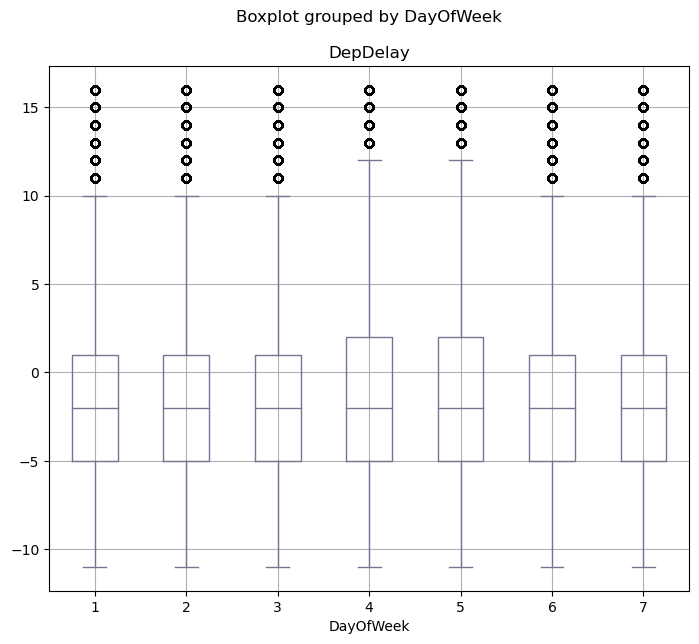

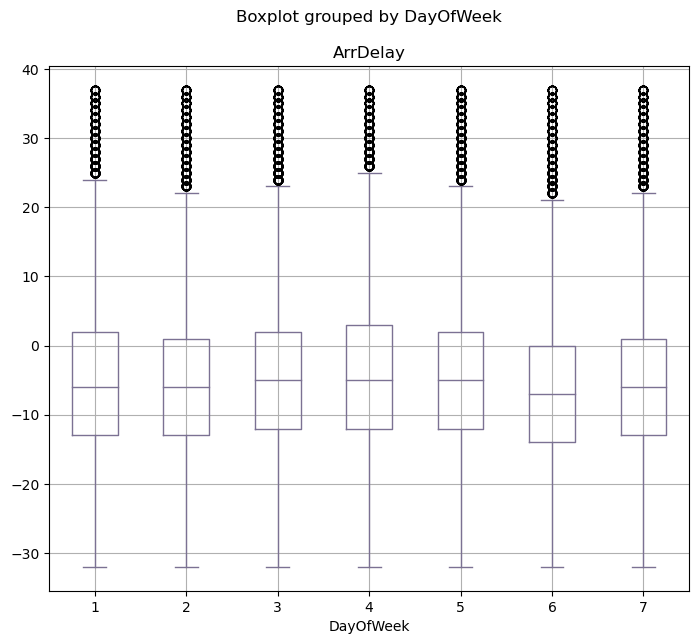

In [24]:
for col in delay_fields:
    df.boxplot(column=col, by="DayOfWeek", figsize=(8,7), color="#7b7193")

**Hangi kalkış havalimanı en yüksek ortalama kalkış gecikmesine sahiptir?**

,DepDelay
OriginAirportName,
Chicago Midway International,2.365960
Dallas Love Field,2.148798
William P Hobby,1.561927
Metropolitan Oakland International,0.964853
Denver International,0.807272
...,...
Memphis International,-2.962737
Tucson International,-2.989154
Ted Stevens Anchorage International,-3.149758


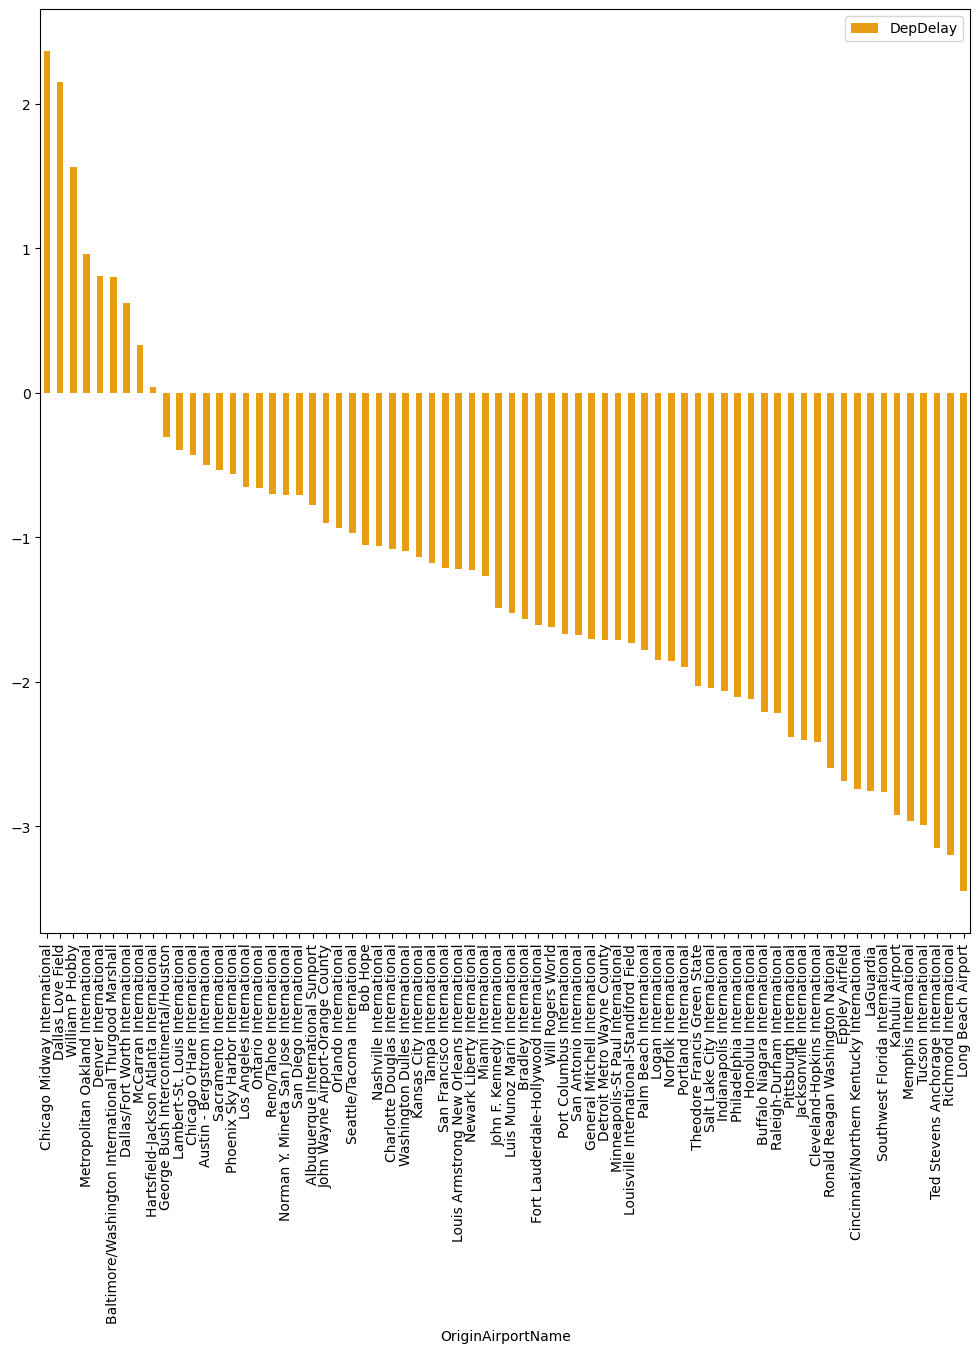

In [28]:
departure_airport_group = df.groupby(df["OriginAirportName"])

mean_departure_delays = pd.DataFrame(departure_airport_group["DepDelay"].mean()).sort_values("DepDelay", ascending=False)
mean_departure_delays.plot(kind = "bar", figsize=(12,12), color="#e89d12")
mean_departure_delays

**Geç kalkışlar, zamanında kalkışlardan daha uzun varış gecikmelerine neden olma eğiliminde midir?**

<Axes: title={'center': 'ArrDelay'}, xlabel='DepDel15'>

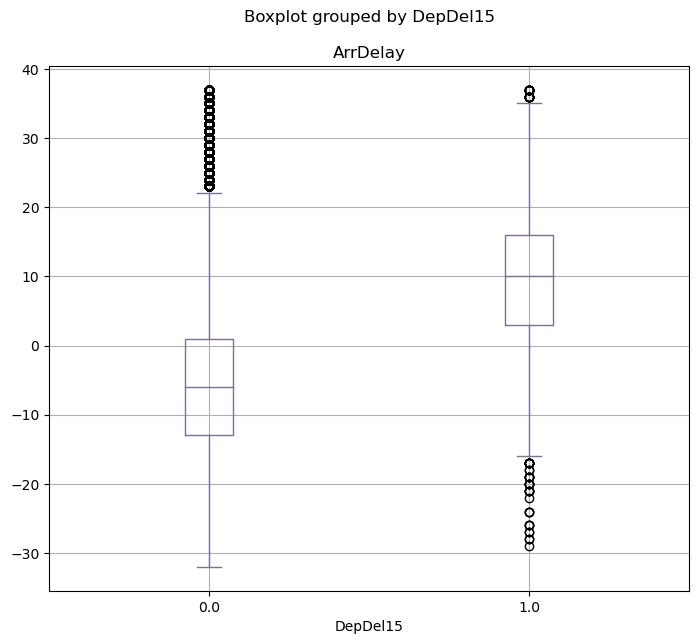

In [29]:
df.boxplot(column="ArrDelay", by="DepDel15", figsize=(8,7), color="#7b7193")

**Hangi güzergahta (başlangıç ​​havalimanından varış havalimanına) en geç varışlar var?**

In [30]:
# Bir rota sütunu ekleyin
routes = pd.Series(df["OriginAirportName"] + " > " + df["DestAirportName"])
df = pd.concat([df, routes.rename("Route")], axis=1)

# Güzergahlara göre gruplandırın
route_group = df.groupby(df.Route)
pd.DataFrame(route_group["ArrDel15"].sum()).sort_values("ArrDel15", ascending=False)

,ArrDel15
Route,
San Francisco International > Los Angeles International,90
Los Angeles International > San Francisco International,69
LaGuardia > Hartsfield-Jackson Atlanta International,68
Los Angeles International > John F. Kennedy International,52
LaGuardia > Charlotte Douglas International,51
...,...
Logan International > Austin - Bergstrom International,0
Logan International > Memphis International,0
Logan International > Port Columbus International,0


**Ortalama varış gecikmesi en yüksek olan rota hangisidir?**

In [31]:
pd.DataFrame(route_group["ArrDelay"].mean()).sort_values("ArrDelay", ascending=False)

,ArrDelay
Route,
Louis Armstrong New Orleans International > Ronald Reagan Washington National,24.500000
Cleveland-Hopkins International > Palm Beach International,18.000000
John F. Kennedy International > Louisville International-Standiford Field,18.000000
Cleveland-Hopkins International > Philadelphia International,12.800000
Memphis International > Denver International,9.758621
...,...
Lambert-St. Louis International > Cleveland-Hopkins International,-20.000000
Eppley Airfield > LaGuardia,-20.750000
Denver International > Kahului Airport,-22.666667
